In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
sns.set_theme(style="whitegrid")

import numpy as np
import math
from scipy.stats import norm, \
    beta, cauchy, expon, rayleigh, uniform, multivariate_t, t, \
    rankdata, kendalltau, pearsonr
from scipy.stats.mstats import spearmanr
import scipy.integrate as integrate
import pandas as pd
from scipy.optimize import brentq, fsolve

### Original Data

| x      | y |
| ----------- | ----------- |
| 0.6      | 0.8       |
| 0.2   | 0.4        |
| 1.2   | 0.5        |
| 0.1   | 0.2        |

### Rank Observations

| x      | y |
| ----------- | ----------- |
| 3   | 4    |
| 2   | 2    |
| 4   | 3    |
| 1   | 1    |

In [3]:
def pobs(X):
    # X.shape = (n,d), n = # of samples, d = dimension of data
    n, d = X.shape
    U = rankdata(X, method='ordinal', axis=0) / float(n+1)  # divide by n+1 to mitigate boundary errors
    return U

In [4]:
# https://documentation.sas.com/doc/en/etsug/15.2/etsug_copula_details03.htm
r = 0.8
P = np.asarray([
    [1, r],
    [r, 1]
])
d = P.shape[0]
n = 500

A = np.linalg.cholesky(P)
Z = np.random.normal(size=(n,d))
U_Gauss = norm.cdf(np.matmul(Z, A))

H1 = np.empty_like(U_Gauss)
H1[:,0] = norm.ppf(U_Gauss[:,0]); H1[:,1] = norm.ppf(U_Gauss[:,1]); 

H2 = np.empty_like(U_Gauss)
H2[:,0] = beta.ppf(U_Gauss[:,0], 2, 5); H2[:,1] = cauchy.ppf(U_Gauss[:,1]); 

U1 = pobs(H1)
U2 = pobs(H2)

<IPython.core.display.Javascript object>


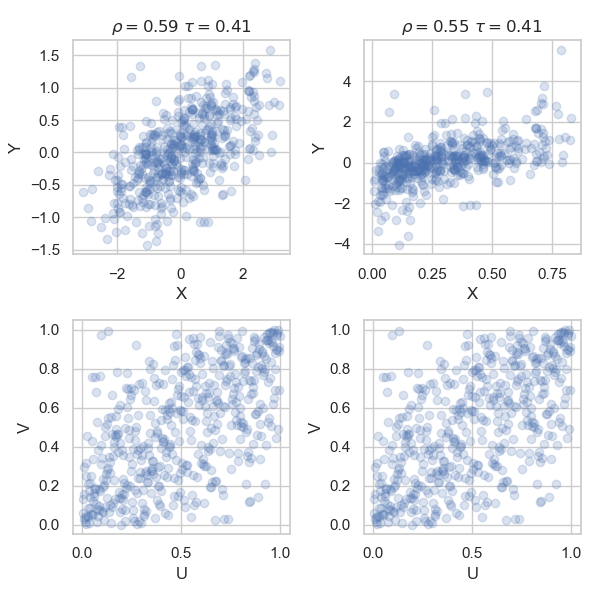

In [5]:
plt.figure(figsize=(6,6))

plt.subplot(2,2,1)
plt.scatter(H1[:,0], H1[:,1], alpha=0.2)
t = kendalltau(H1[:,0], H1[:,1])
plt.title(r'$\rho=%0.02f \ \tau=%0.02f$' % (pearsonr(H1[:,0], H1[:,1])[0], t.correlation))
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(2,2,2)
plt.scatter(H2[:,0], H2[:,1], alpha=0.2)
t = kendalltau(H2[:,0], H2[:,1])
plt.title(r'$\rho=%0.02f \ \tau=%0.02f$' % (pearsonr(H2[:,0], H2[:,1])[0], t.correlation))
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(2,2,3)
plt.scatter(U1[:,0], U1[:,1], alpha=0.2)
plt.xlabel('U')
plt.ylabel('V')

plt.subplot(2,2,4)
plt.scatter(U2[:,0], U2[:,1], alpha=0.2)
plt.xlabel('U')
plt.ylabel('V')

plt.tight_layout()

<IPython.core.display.Javascript object>


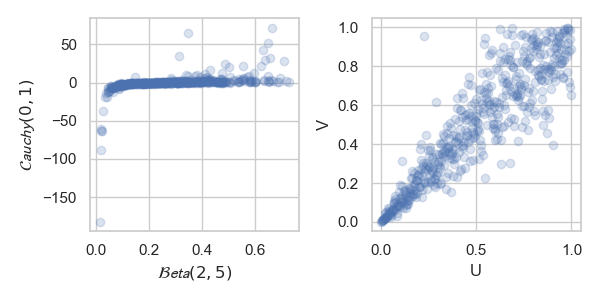

In [6]:
# https://medium.com/@financialnoob/introduction-to-copulas-part-2-9de74010ed87
alpha = 6
u = np.random.rand(n)
t = np.random.rand(n)
v = ((t / u**(-alpha-1))**(-alpha/(1+alpha)) - u**(-alpha) + 1)**(-1/alpha)
U_clayton = np.vstack([u, v]).T

H2 = np.empty_like(U_clayton)
H2[:,0] = beta.ppf(U_clayton[:,0], 2, 5); H2[:,1] = cauchy.ppf(U_clayton[:,1]); 

plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.scatter(H2[:,0], H2[:,1], alpha=0.2)
plt.xlabel('$\mathcal{Beta}(2,5)$')
plt.ylabel('$\mathcal{Cauchy}(0,1)$')

U = pobs(H2)
plt.subplot(1,2,2)
plt.scatter(U[:,0], U[:,1], alpha=0.2)
plt.xlabel('U')
plt.ylabel('V')

plt.tight_layout()

### Kendall's Tau

$$ \tau = 4 \int_0^1 \int_0^1 C(x,y) dC(x,y) dx dy $$
$$ \tau = \frac{2}{n(n-1)} \sum_{i<j} \text{sgn}(x_i-x_j) \text{sgn}(y_i-y_j) $$

### Gaussian Copula
$$ \rho = sin\left(\tau \frac{\pi}{2}\right) $$

In [7]:
def ktau2gaussian(val, dependency='kendall'):
    if(dependency=='kendall'):
        r = np.sin(val * math.pi/2.0)
    elif(dependency=='spearman'):
        r = 2*np.sin(val * math.pi/6.0)
    return r
# ML approach: 
# fun = @(theta) -sum(log(copulapdf(family,u,theta)+eps));
# theta = fminbnd(fun,-1,1,optimset('Display','off'));

### Clayton Copula
$$ \alpha = \frac{2\tau}{1-\tau} $$

In [8]:
def ktau2clayton(val, dependency='kendall'):
    if(dependency=='kendall'):
        if(val<0 or val>=1):
            raise ValueError('Valid values of Kendall\'s Tau for the Clayton Copula are [0,1)')
        d = 2.0*val/(1.0-val)
    elif(dependency=='spearman'):
        raise NotImplementedError('Spearmans Rho currently unsupported for Clayton Copula family!')
    
    return d

### Gumbel Copula
$$ \alpha = \frac{1}{1-\tau} $$

In [9]:
def ktau2gumbel(val, dependency='kendall'):
    if(dependency=='kendall'):
        if(val<0 or val>=1):
            raise ValueError('Valid values of Kendall\'s Tau for the Gumbel Copula are [0,1)')
        d = 1.0/(1.0-val)
    elif(dependency=='spearman'):
        raise NotImplementedError('Spearmans Rho currently unsupported for Gumbel Copula family!')
    
    return d

### Frank Copula
$$ 4 \frac{\mathcal{D}_1(\alpha) - 1 }{\alpha} + 1 - \tau = 0 $$
$$ \mathcal{D}_n(x) = \frac{n}{x^n} \int_0^x \frac{t^n}{e^t-1} dt $$

In [10]:
def debye(x, n):
    """
    Evaluate the Debye function.
    See http://en.wikipedia.org/wiki/Debye_function for details
    """
    # ensure n is a float
    n = float(n)
    
    sol = integrate.quad( lambda t: pow(t,n)/(np.exp(t)-1.0) , 0.0, x)
    return n*sol[0]/pow(x,n)

def _frank_kendall_fopt(alpha, tau):
    return 4*( debye(alpha,1) - 1 )/alpha + 1 - tau

def ktau2frank(val, dependency='kendall'):
    if(dependency=='kendall'):
        return fsolve(_frank_kendall_fopt, 1, args=(val))[0]
    elif(dependency=='spearman'):
        # TODO --  use function solvers in scipy to invert debye function for the closed form solution
        raise NotImplementedError('Spearmans Rho currently unsupported for Frank Copula family!')
    
    return r

In [11]:
## Gaussian Example
r = 0.5
P = np.asarray([
    [1, r],
    [r, 1]
])
d = P.shape[0]
n = 1000

A = np.linalg.cholesky(P)
Z = np.random.normal(size=(n,d))
U_Gauss = norm.cdf(np.matmul(Z, A))

H1 = np.empty_like(U_Gauss)
H1[:,0] = norm.ppf(U_Gauss[:,0]); H1[:,1] = norm.ppf(U_Gauss[:,1]); 

H2 = np.empty_like(U_Gauss)
H2[:,0] = beta.ppf(U_Gauss[:,0], 2, 5); H2[:,1] = cauchy.ppf(U_Gauss[:,1]); 

t1 = kendalltau(H1[:,0], H1[:,1]); c1_param = ktau2gaussian(t1.correlation)
t2 = kendalltau(H2[:,0], H2[:,1]); c2_param = ktau2gaussian(t2.correlation)

print(r, c1_param, c2_param, pearsonr(H1[:,0], H1[:,1])[0], pearsonr(H2[:,0], H2[:,1])[0])

0.5 0.45206167536789066 0.45206167536789066 0.4526917493787385 0.10100828681890764


In [12]:
## Clayton Example

alpha = 6
u = np.random.rand(n)
t = np.random.rand(n)
v = ((t / u**(-alpha-1))**(-alpha/(1+alpha)) - u**(-alpha) + 1)**(-1/alpha)
U_clayton = np.vstack([u, v]).T

H1 = np.empty_like(U_clayton)
H1[:,0] = norm.ppf(U_clayton[:,0]); H1[:,1] = norm.ppf(U_clayton[:,1]); 

H2 = np.empty_like(U_clayton)
H2[:,0] = beta.ppf(U_clayton[:,0], 2, 5); H2[:,1] = cauchy.ppf(U_clayton[:,1]); 

t1 = kendalltau(H1[:,0], H1[:,1]); c1_param = ktau2clayton(t1.correlation)
t2 = kendalltau(H2[:,0], H2[:,1]); c2_param = ktau2clayton(t2.correlation)

print(alpha, c1_param, c2_param)

6 5.780616218573789 5.780616218573789


In [13]:
## Gumbel Example
def gumbel_phi(t, alpha):
    return (-np.log(t))**alpha

def gumbel_phi_inv(t, alpha):
    return np.exp(-t**(1/alpha))

def gumbel_K(t, alpha):
    return t * (alpha - np.log(t)) / alpha

alpha = 6
t1 = np.random.rand(n)
t2 = np.random.rand(n)

w = []
for t in t2:
    func = lambda w: gumbel_K(w, alpha=alpha) - t
    w.append(brentq(func, 0.0000000001, 0.9999999999))
w = np.array(w).flatten()

u = gumbel_phi_inv(t1 * gumbel_phi(w, alpha=alpha), alpha=alpha)
v = gumbel_phi_inv((1-t1) * gumbel_phi(w, alpha=alpha), alpha=alpha)
U_gumbel = np.vstack([u, v]).T

H1 = np.empty_like(U_gumbel)
H1[:,0] = norm.ppf(U_gumbel[:,0]); H1[:,1] = norm.ppf(U_gumbel[:,1]); 

H2 = np.empty_like(U_gumbel)
H2[:,0] = beta.ppf(U_gumbel[:,0], 2, 5); H2[:,1] = cauchy.ppf(U_gumbel[:,1]); 

t1 = kendalltau(H1[:,0], H1[:,1]); c1_param = ktau2gumbel(t1.correlation)
t2 = kendalltau(H2[:,0], H2[:,1]); c2_param = ktau2gumbel(t2.correlation)

print(alpha, c1_param, c2_param)

6 5.674846625766868 5.674846625766868


In [14]:
## Frank Example

def frank_phi(t, alpha):
    return -np.log((np.exp(-alpha*t) - 1) / (np.exp(-alpha) - 1))

def frank_phi_inv(t, alpha):
    return -1/alpha * np.log((np.exp(-alpha) - 1) / np.exp(t) + 1)

def frank_K(t, alpha):
    return (t + (1 - np.exp(alpha*t)) * np.log((1-np.exp(alpha*t)) * 
                                               np.exp(-alpha*t+alpha) / (1-np.exp(alpha))) / alpha)
  
alpha = 6
t1 = np.random.rand(n)
t2 = np.random.rand(n)

w = []
for t in t2:
    func = lambda w: frank_K(w, alpha=alpha) - t
    w.append(brentq(func, 0.0000000001, 0.9999999999))
w = np.array(w).flatten()

u = frank_phi_inv(t1 * frank_phi(w, alpha=alpha), alpha=alpha)
v = frank_phi_inv((1-t1) * frank_phi(w, alpha=alpha), alpha=alpha)
U_frank = np.vstack([u,v]).T

H1 = np.empty_like(U_frank)
H1[:,0] = norm.ppf(U_frank[:,0]); H1[:,1] = norm.ppf(U_frank[:,1]); 

H2 = np.empty_like(U_frank)
H2[:,0] = beta.ppf(U_frank[:,0], 2, 5); H2[:,1] = cauchy.ppf(U_frank[:,1]); 

t1 = kendalltau(H1[:,0], H1[:,1]); c1_param = ktau2frank(t1.correlation)
t2 = kendalltau(H2[:,0], H2[:,1]); c2_param = ktau2frank(t2.correlation)

print(alpha, c1_param, c2_param)

6 5.8345052185139705 5.8345052185139705
